In [1]:
# !pip install matplotlib
# !pip install easydev
# !pip install shapely
# !pip install colormap

In [2]:
import os, json
import logging

from matplotlib import pyplot as plt

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2 as cv
import numpy as np
import shapely.wkt as wkt
import shapely.geometry as geometry
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from colormap.colors import Color, hex2rgb
from tensorflow.keras.models import model_from_json, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, BatchNormalization, Dropout, concatenate, Reshape, Softmax, Conv2DTranspose,MaxPooling2D

physical_devices = tf.config.experimental.list_physical_devices('GPU')

print('\n###########################################################################')
print('Tensorflow version : ', tf.__version__)
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)
    print("Consuming GPU for Training.") 
else:
    print("WARNING: Could not find GPU! Using CPU only.")
print('###########################################################################')


###########################################################################
Tensorflow version :  2.6.0
Consuming GPU for Training.
###########################################################################


In [3]:
image_dir = 'data/segmentation_aug/images/'
mask_dir = 'data/segmentation_aug/masks/'

input_shape = (256, 256, 3)
output_shape_orig = (256, 256, 2)
output_shape_new = (65536, 2)
# input_shape = (128, 128, 3)
# output_shape_orig = (128, 128, 2)
# output_shape_new = (16384, 2)

data_npz = 'weights/data_segmentation.npz'
segmentation_weights = 'weights/disease segmentation.h5'

In [4]:
# mask_files = 'data/segmentation/masks/'
# flatten_masks = []
# for mask_file in os.listdir(mask_files):
#     mask = cv.imread(mask_files+mask_file)
#     mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
#     mask = cv.resize(mask, (256, 256), interpolation=cv.INTER_NEAREST)
#     flatten_mask = list(set(mask.flatten().tolist()))
#     flatten_mask = (flatten_mask[0], flatten_mask[1])
#     if flatten_mask == (0,38):
#         idxs = np.where(mask != 0)
#         mask[idxs] = 1

#         plt.imshow(mask)
#         plt.show()

#         break

#     flatten_masks.append((flatten_mask[0], flatten_mask[1]))
# set(flatten_masks)
# {(0, 1), (0, 2), (0, 19), (0, 32), (0, 33), (0, 38)}

In [5]:

def preprocess_input(image_path):                      #Used to process segmentation input
    img = cv.imread(image_path)
    original_img = img
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)            #convert image to RGB
    img = np.asarray(img).astype("f")
    img = cv.resize(img, (input_shape[0], input_shape[1]), interpolation = cv.INTER_AREA)
    return img/255.0, original_img

def preprocess_output(mask_path):
    label = cv.imread(mask_path)
    label = cv.cvtColor(label, cv.COLOR_BGR2GRAY)
    
    label = label.astype(np.float32)                       #convert mask image to float
    # label = label / 255.0
    label = cv.resize(label, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_NEAREST)
        
    label = label.reshape(label.shape[0] * label.shape[1],)

    # set value 1 where pixcel value != 0
    idxs = np.where(label != 0)
    label[idxs] = 1

    label = tf.one_hot(label, 2).numpy()
    return label  

In [6]:
#pre -process the data set using above fucntions
def prepare_dataset():
    inputs = []
    outputs = []
    
    for image_file in os.listdir(image_dir):                         
        if image_file.endswith('.jpg'):
            image_name = image_file.split('.')[0]
            mask_file = image_name + '.png'
            
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, mask_file)
            if (os.path.exists(image_path)) and (os.path.exists(mask_path)):
                input_, _ = preprocess_input(image_path)
                label_ = preprocess_output(mask_path)
                inputs.append(input_)
                outputs.append(label_)

    inputs = np.array(inputs)
    outputs = np.array(outputs)
    return inputs, outputs

In [7]:
#loading the saved data set
if not os.path.exists(data_npz):
    inputs, outputs = prepare_dataset()
    np.savez(
            data_npz, 
            inputs=inputs, 
            outputs=outputs
            )
else:
    data = np.load(data_npz)
    inputs = data['inputs']
    outputs = data['outputs']

In [8]:
idxs = np.random.choice(len(inputs), 1500, replace=False)
X = inputs[idxs]
Y = outputs[idxs]

In [9]:
print('input shape : ', X.shape)
print('output shape : ', Y.shape)

input shape :  (1500, 256, 256, 3)
output shape :  (1500, 65536, 2)


In [10]:
# raw_output = Y.argmax(axis=-1).reshape(-1,)

# class_weights = compute_class_weight(
#                                 'balanced',
#                                  classes = np.unique(raw_output),
#                                  y = raw_output)

# '''

# Eqn : Total Number of Samples / (2 * Number of Samples in Given Class)

# '''
# class_weights = {i : class_weights[i] for i in range(len(set(raw_output)))}
# class_weights

class_weights = {0: 0.5971601576281471, 1: 3.07307116520749}

In [11]:
binary_output = Y.argmax(axis=-1)
sample_weight = np.zeros((outputs.shape[0], outputs.shape[1]))
sample_weight[np.where( binary_output == 0)] = class_weights[0]
sample_weight[np.where( binary_output == 1)] = class_weights[1]

In [12]:
#setup the model Using unet model 
def downsample_block(filters, input):                                  #decrease the size of feature map
    conv = Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(input)
    conv = Dropout(0.2)(conv)
    conv = Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(conv)
    pool = MaxPool2D((2, 2))(conv)
    return pool, conv

def upsample_block(filters, conv, conv_p):                                 #increase the size of feature map
    up = concatenate([UpSampling2D((2, 2))(conv), conv_p], axis=-1)
    conv_n = Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(up)
    conv_n = Dropout(0.2)(conv_n)
    conv_n = Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(conv_n)
    return conv_n

def Unet_model():
    input = Input(shape=input_shape, name='input')

    if input_shape[0] == 128:
        c1 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(input)
        c1 = Dropout(0.1)(c1)
        c1 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c1)
        p1 = MaxPooling2D(pool_size=(2, 2))(c1)

        c2 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p1)
        c2 = Dropout(0.1)(c2)
        c2 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c2)
        p2 = MaxPooling2D(pool_size=(2, 2))(c2)

        c3 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p2)
        c3 = Dropout(0.2)(c3)
        c3 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c3)
        p3 = MaxPooling2D(pool_size=(2, 2))(c3)

        c4 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p3)
        c4 = Dropout(0.2)(c4)
        c4 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c4)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(p4)
        c5 = Dropout(0.3)(c5)
        c5 = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c5)

        # Expansive path:
        u6 = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u6)
        c6 = Dropout(0.2)(c6)
        c6 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u7)
        c7 = Dropout(0.2)(c7)
        c7 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u8)
        c8 = Dropout(0.1)(c8)
        c8 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(u9)
        c9 = Dropout(0.1)(c9)
        c9 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(c9)
        logits = Conv2D(2, (1, 1))(c9)
        
        logits = Reshape(
                    output_shape_new, 
                    input_shape = output_shape_orig
                    )(logits)
        output = Softmax()(logits)
        
                         

    model = Model(
                inputs=input, 
                outputs=output,
                name='disease_classification'
                )
    model.summary()
  
    return model

def train(model):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    patience=15,
                                                    restore_best_weights=True
                                                    )   

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(                       #method use for perefomance
                                                    0.0005,
                                                    decay_steps=100000,
                                                    decay_rate=0.96,
                                                    staircase=True
                                                    )

    model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(lr_schedule),
                metrics=['accuracy', recall, precision],
                sample_weight_mode="temporal"
                )
    model.fit(
            X,
            Y,
            epochs=100,
            batch_size=4,
            validation_split = 0.15,
            # callbacks=[early_stopping],
            sample_weight=sample_weight
                )
    
    model.save(segmentation_weights)
    return model

In [13]:
model = Unet_model()
train(model)

Model: "disease_classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
_____________________________________________________________________________

In [14]:
model = tf.keras.models.load_model(segmentation_weights)

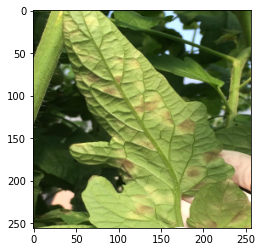

In [15]:
idx = 22
test_image = X[idx]
plt.imshow(test_image)
plt.show()

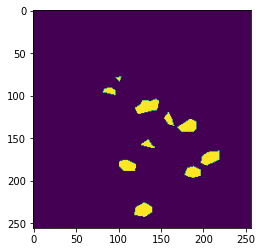

In [16]:
test_mask = Y[idx].argmax(axis=-1)
plt.imshow(test_mask.reshape(output_shape_orig[0], output_shape_orig[1], 1))
plt.show()

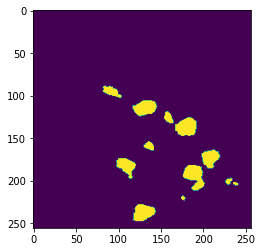

In [17]:
Prediction = model.predict(np.expand_dims(test_image, axis=0))
Prediction = Prediction.squeeze().argmax(axis=-1)

plt.imshow(Prediction.reshape(output_shape_orig[0], output_shape_orig[1], 1))
plt.show()